In [12]:
import os
import sys
import numpy as np
from skimage import io
import itk
from scipy import ndimage
import itkwidgets
import matplotlib.pyplot as plt

In [14]:
animal = 'DK41'
DATA = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [ ]:
filename = 'allen_50um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixedImage = itk.imread(fixedFilepath, itk.F)

In [ ]:
movingFilepath = os.path.join(DATA, 'moving_volume.256.tif')
movingImage = itk.imread(movingFilepath, itk.F)

In [ ]:

init_transform = itk.VersorRigid3DTransform[itk.D].New()  # Represents 3D rigid transformation with unit quaternion
init_transform.SetIdentity()
transform_initializer = itk.CenteredVersorTransformInitializer[
    type(fixedImage), type(movingImage)
].New()
transform_initializer.SetFixedImage(fixedImage)
transform_initializer.SetMovingImage(movingImage)
transform_initializer.SetTransform(init_transform)
transform_initializer.GeometryOn()  # We compute translation between the center of each image
transform_initializer.ComputeRotationOff()  # We have previously verified that spatial orientation aligns
transform_initializer.InitializeTransform()
init_transform = init_transform.GetInverseTransform()
print(init_transform)


In [ ]:
itkwidgets.compare(movingImage,fixedImage)

In [ ]:
# init transform end
# Apply translation without resampling the image by updating the image origin directly
change_information_filter = itk.ChangeInformationImageFilter[type(movingImage)].New()
change_information_filter.SetInput(movingImage)
change_information_filter.SetOutputOrigin(
    init_transform.TransformPoint(itk.origin(movingImage))
)
change_information_filter.ChangeOriginOn()
change_information_filter.UpdateOutputInformation()
source_image_init = change_information_filter.GetOutput()

In [ ]:
TRANSPATH = os.path.join(DATA, 'init-transform.tfm')
itk.transformwrite([init_transform], TRANSPATH)

In [ ]:
saved_init_transform = itk.transformread(TRANSPATH)[0]
print(saved_init_transform)

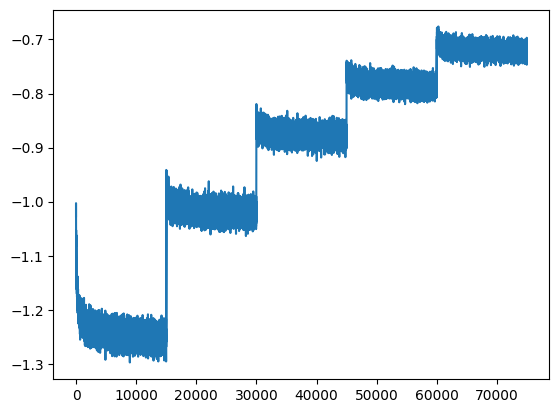

In [45]:
iterations = [0,1,2,3,5]
xl = []
yl = []
count = 0
for iteration in iterations:
    infile = os.path.join(DATA, 'elastix_output/allen25um', f'IterationInfo.3.R{iteration}.txt')
    with open(infile, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            text_list = line.split("\t")
            yl.append(count)
            xl.append(float(text_list[1]))
            count += 1


plt.plot(yl, xl)
plt.show()
